In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import pandas as pd

In [ ]:
plss, serie_vulnerabilidad = calcular_periodo_vulnerabilidad('20-04-24', '20-06-12')

In [ ]:
guardar_shape_vulnerabilidad(serie_vulnerabilidad, 'vulnerabilidad_pls_20-06-04.shp', '20-06-16')

In [ ]:
serie_vulnerabilidad.head()

In [ ]:
mapas_serie_letalidad(serie_vulnerabilidad, lapso_dias=1)
mapas_serie_vulnerabilidad(serie_vulnerabilidad, lapso_dias=1)

In [ ]:
diccionario_indicadores_old = pd.read_csv('datos/variablesf.csv', encoding='latin-1', index_col=False)
diccionario_indicadores = pd.read_csv('datos/diccionario_vulnerabilidad.csv', encoding='UTF-8', index_col=False)

faltantes = diccionario_indicadores_old.loc[diccionario_indicadores_old.Variable.isin(list(set(diccionario_indicadores_old.Variable).difference(diccionario_indicadores.campo)))].copy()

faltantes.sort_values(by='Variable', inplace=True)
faltantes.rename(columns={'Variable': 'campo', 'Descripcin': 'descriptor'}, inplace=True)

caracteristicas_indice = caracteristicas_modelos_municipios(df_0, poblaciones=False, i_vuln=False)
caracteristicas_indice

diccionario_indicadores = diccionario_indicadores.loc[diccionario_indicadores.campo.isin(caracteristicas_indice),:].sort_values(by='campo')

# Objetivo

Identificar poblaciones vulnerables ante la amenaza de COVID-19, donde entendemos vulnerabilidad como mayor suceptibilidad a padecer efectos adversos por la enfermedad.

La vulnerabilidad de una población la evaluamos con base en sus características de desarrollo social, economía, y salubridad. El índice de vulnerabilidad produce: un ordenamiento de los municipios de México de acuerdo con el riesgo que representa para sus habitantes la exposisción al Sars-Cov-2, y una lista con los indicadores que se observan más correlacionados con este riesgo. Un objetivo particular es tener una evaluación preliminar sobre el riesgo potencial para municipios donde todavía no se han reportado casos. 

La estrategia para construir el índice es usar como variable de respuesta la letalidad reportada en cada muncipio con al menos diez casos confirmados de SARS-COV-2. Para estudiar el fenómeno de letalidad integramos un conjunto de indicadores sociales, económicos y de salubridad y encontramos la combinación de estos que más se relaciona con el nivel de letalidad de COVID-19. Con esta combinación generamos un índice que nos da un ordenamiento de municipios de acuerdo al riesgo al sus habitantes estarían expuestos si se presenta un brote de Sars-COV-2 en esa población. 

El índice como veremos más adelante muestra que las entidades donde se acumulan más municipios vulnerables son: Oaxaca, Chiapas, Guerrero, Veracruz y Puebla. Otras entidades aunque la mediana de sus municipios tienen vulnerabilidades medias y bajas, se caracterizan por tener algunos de los municipios con una vulnerabilidad dentro de las más altas del país como Chihuahua, Durango, y Nayarit son casos en esta categoría. Por ejemplo, el Municipio de [Batopilas de Manuel Gómez Morín](https://es.wikipedia.org/wiki/Batopilas) en Chihuahua que se encuentra en la Sierra Tarahumara es uno de los cinco municipios con mayor vulnerabilidad.

El conjunto de indicadores que utilizamos para este análisis provienen de CONEVAL, INEGI y CLUES. 

Cabe mencionar que aunque este índice está ajustado para maximizar la información que nos pueden dar los indicadores considerados sobre riesgo de un alto porcentaje de defunciones, también nos puede indicar otras vulnerabilidades de una población, por ejemplo, son poblaciones que en general tendrán más complicaciones económicas y alimentarias. 

# Definiciones


**Amenaza**
: 'La potencial ocurrencia de eventos físicos de origen natural o antropogénico que pueden tener efectos adversos sobre los elementos vulnerables y expuestos', [^diaz_cervantes]

**Exposición**
: 'la intensidad y duración en que los elementos, como personas, ecosistemas, infraestructura y servicios, están presentes en lugares que podrían verse afectados negativamente'. [^diaz_cervantes]

**Vulnerabilidad**
: 'La propensión o predisposición a verse afectado adversamente por una amenaza', en nuestro caso COVID-19. [^diaz_cervantes], [^IPCC]

**Riesgo**
: 'la probabilidad de que se produzcan alteraciones severas en el funcionamiento normal de una comunidad o una sociedad debido a la ocurrencia de fenómenos físicos peligrosos que interactúan con condiciones sociales vulnerables', [^diaz_cervantes], [^IPCC]

**Letalidad**
: la proporción de casos de COVID-19 que terminan en defunción.

[^diaz_cervantes]: DIAZ CARAVANTES, Rolando Enrique. Vulnerabilidad y riesgo como conceptos indisociables para el estudio del impacto del cambio climático en la salud. Región y sociedad [online]. 2018, vol.30, n.73 [citado  2020-06-18], 0006. Disponible en: <http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S1870-39252018000300006&lng=es&nrm=iso>. ISSN 1870-3925.  http://dx.doi.org/10.22198/rys.2018.73.a968.

[^IPCC]: Managing the risks of extreme events and disasters to advance climate change adaptation, https://www.ipcc.ch/report/managing-the-risks-of-extreme-events-and-disasters-to-advance-climate-change-adaptation/

# Datos

El índice de vulnerabilidad lo construimos relacionando indicadores de CONEVAL, INEGI y estadísticas CLUES, con la letalidad de COVID-19 observada en los municipios donde ya se han confirmado casos de infección de Sars-Cov-2.

Las fuentes de datos para el conjunto de indicadores pertenecen a cuatro categorías. La siguiente lista presenta la fuente y la categoría a la que pertence cada conjunto de indicadores:

1. Social:
    * Fuente: CONEVAL, rezago social, 2015
    * Producto: Índice de rezago social por municipio
    * URL: 
2. Economía:
    * Fuente: CONEVAL, pobreza, 2015
    * Producto: Indicadores de pobreza por municipio
    * URL:
3. Salud:
    * Fuente: INEGI
    * Producto: estadísticas vitales, 2015
    * URL:
4. Infraestructura de salud:
    * Fuente: CLUES
    * Producto: 
    * URL:
    
    

# Índice de vulnerabilidad COVID-19

## Mapa de vulnerabilidad 1 de junio de 2020
<img src="resultados/mapas/vulnerabilidad/20_06_01_vulnerabilidad.jpg" width="80%" style="float: left;" />


### Lista 10 municipios más vulnerables

De acuerdo con el índice, los diez municipios más vulnerables son los siguientes. Un dato notable es que de los diez municipios más vulnerables seis no tienen coasos reportados. En general los municipios más vulnerables son municipios con muy pocos casos, o sin casos.

In [ ]:
pd.set_option('display.max_colwidth', 50)
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 1))].copy()
display(df.sort_values(by='valor', ascending=False).head(10)[['ENTIDAD_RES', 'MUNICIPIO_RES',
                                                              'conteo',
                                                              'defunciones', 
                                                              'valor',
                                                              'covid_confirmados_100k', 'tasa_covid_letal',
                                                              'dia_ajuste']])

,ENTIDAD_RES,MUNICIPIO_RES,conteo,defunciones,valor,covid_confirmados_100k,tasa_covid_letal,dia_ajuste
93969,DURANGO,MEZQUITAL,3.0,0.0,26.892256,7.390437,0.0,2020-06-01
94118,GUERRERO,COCHOAPA EL GRANDE,0.0,0.0,26.406268,0.000000,NaN,2020-06-01
93880,CHIHUAHUA,BATOPILAS DE MANUEL GÓMEZ MORÍN,0.0,0.0,25.959841,0.000000,NaN,2020-06-01
94612,NAYARIT,DEL NAYAR,0.0,0.0,25.806419,0.000000,NaN,2020-06-01
94845,OAXACA,SAN JOSÉ TENANGO,2.0,1.0,25.085008,10.552976,50.0,2020-06-01
95203,OAXACA,SANTOS REYES YUCUNÁ,0.0,0.0,24.191547,0.000000,NaN,2020-06-01
93831,CHIAPAS,SITALÁ,0.0,0.0,24.035764,0.000000,NaN,2020-06-01
93771,CHIAPAS,CHALCHIHUITÁN,0.0,0.0,24.000646,0.000000,NaN,2020-06-01
95917,VERACRUZ DE IGNACIO DE LA LLAVE,TEHUIPANGO,0.0,0.0,23.923357,0.000000,NaN,2020-06-01
95140,OAXACA,SANTIAGO IXTAYUTLA,0.0,0.0,23.866417,0.000000,NaN,2020-06-01


### Los 10 municipios menos vulnerables

In [ ]:
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 1))].copy()
display(df.sort_values(by='valor').head(10)[['ENTIDAD_RES', 'MUNICIPIO_RES',
                                                              'conteo',
                                                              'defunciones', 
                                                              'valor',
                                                              'covid_confirmados_100k', 'tasa_covid_letal',
                                                              'dia_ajuste']])

,ENTIDAD_RES,MUNICIPIO_RES,conteo,defunciones,valor,covid_confirmados_100k,tasa_covid_letal,dia_ajuste
93954,CIUDAD DE MÉXICO,MIGUEL HIDALGO,1039.0,87.0,6.401207,273.691864,8.373436,2020-06-01
93952,CIUDAD DE MÉXICO,BENITO JUÁREZ,960.0,81.0,6.633657,221.347081,8.437500,2020-06-01
94662,NUEVO LEÓN,MONTERREY,376.0,27.0,6.738978,33.427125,7.180851,2020-06-01
94244,JALISCO,GUADALAJARA,542.0,54.0,6.766276,36.049099,9.963100,2020-06-01
93953,CIUDAD DE MÉXICO,CUAUHTÉMOC,1468.0,163.0,7.043029,267.587303,11.103542,2020-06-01
93891,CHIHUAHUA,CHIHUAHUA,388.0,44.0,7.444008,40.868132,11.340206,2020-06-01
93943,CIUDAD DE MÉXICO,GUSTAVO A. MADERO,3254.0,412.0,7.793302,276.473342,12.661340,2020-06-01
94669,NUEVO LEÓN,SAN NICOLÁS DE LOS GARZA,97.0,9.0,7.888651,20.457100,9.278351,2020-06-01
93941,CIUDAD DE MÉXICO,COYOACÁN,1625.0,109.0,7.943262,261.274182,6.707692,2020-06-01
95596,SONORA,HERMOSILLO,759.0,21.0,7.945927,80.227979,2.766798,2020-06-01


### Los 10 municipios con más de 500K habitantes más vulnerables

In [ ]:
pd.set_option('display.max_colwidth', 50)
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 1))].copy()
display(df[df.pob2020 > 500000].sort_values(by='valor', ascending=False).head(10)[['ENTIDAD_RES', 'MUNICIPIO_RES',
                                                              'conteo',
                                                              'defunciones', 
                                                              'valor',
                                                              'covid_confirmados_100k', 'tasa_covid_letal',
                                                              'dia_ajuste']])

,ENTIDAD_RES,MUNICIPIO_RES,conteo,defunciones,valor,covid_confirmados_100k,tasa_covid_letal,dia_ajuste
94041,GUERRERO,ACAPULCO DE JUÁREZ,1218.0,120.0,12.408702,144.862898,9.852217,2020-06-01
94361,MÉXICO,CHIMALHUACÁN,730.0,93.0,12.351988,101.359748,12.739726,2020-06-01
94369,MÉXICO,IXTAPALUCA,595.0,93.0,11.340707,107.978818,15.630252,2020-06-01
94306,JALISCO,TONALÁ,132.0,12.0,10.511657,22.850495,9.090909,2020-06-01
93849,CHIAPAS,TUXTLA GUTIÉRREZ,771.0,31.0,10.500756,116.361375,4.020752,2020-06-01
95677,TAMAULIPAS,MATAMOROS,320.0,33.0,10.379323,58.595717,10.312500,2020-06-01
94001,GUANAJUATO,CELAYA,134.0,25.0,10.295751,25.243962,18.656716,2020-06-01
93681,BAJA CALIFORNIA,ENSENADA,302.0,45.0,10.252654,56.328256,14.900662,2020-06-01
94011,GUANAJUATO,IRAPUATO,145.0,6.0,10.242770,23.743245,4.137931,2020-06-01
95845,VERACRUZ DE IGNACIO DE LA LLAVE,XALAPA,74.0,6.0,10.187712,14.412505,8.108108,2020-06-01


### Los 10 municipios con más de 500K habitantes menos vulnerables

In [ ]:
df[df.pob2020 > 500000].sort_values(by='valor').head(10)[['ENTIDAD_RES',
                                                           'MUNICIPIO_RES',
                                                           'conteo',
                                                           'defunciones',
                                                           'valor', 
                                                           'covid_confirmados_100k', 'tasa_covid_letal',
                                                           'dia_ajuste']]

,ENTIDAD_RES,MUNICIPIO_RES,conteo,defunciones,valor,covid_confirmados_100k,tasa_covid_letal,dia_ajuste
94662,NUEVO LEÓN,MONTERREY,376.0,27.0,6.738978,33.427125,7.180851,2020-06-01
94244,JALISCO,GUADALAJARA,542.0,54.0,6.766276,36.049099,9.963100,2020-06-01
93953,CIUDAD DE MÉXICO,CUAUHTÉMOC,1468.0,163.0,7.043029,267.587303,11.103542,2020-06-01
93891,CHIHUAHUA,CHIHUAHUA,388.0,44.0,7.444008,40.868132,11.340206,2020-06-01
93943,CIUDAD DE MÉXICO,GUSTAVO A. MADERO,3254.0,412.0,7.793302,276.473342,12.661340,2020-06-01
93941,CIUDAD DE MÉXICO,COYOACÁN,1625.0,109.0,7.943262,261.274182,6.707692,2020-06-01
95596,SONORA,HERMOSILLO,759.0,21.0,7.945927,80.227979,2.766798,2020-06-01
94629,NUEVO LEÓN,APODACA,175.0,14.0,8.007736,26.286775,8.000000,2020-06-01
96020,YUCATÁN,MÉRIDA,1072.0,84.0,8.127253,111.219356,7.835821,2020-06-01
93731,COAHUILA DE ZARAGOZA,SALTILLO,125.0,7.0,8.256110,14.381305,5.600000,2020-06-01


# Métodos




## Índice de vulnerabilidad estructural (Análisis de componentes principales)

### Descripción

##  Índice de vulnerabilidad ante COVID-19

El método utilizado para construir este índice es regresión por mínimos cuadrados parciales. Éste método busca la combinación lineal que 

### Descripción

Este índice explora la letalidad observada de COVID-19 en cada municipio y su relación con indicadores de los municipios sobre carencias sociales, de pobreza, de salud y de infrestructura de salud. Para realizar este ajuste sólo consideramos municipios con al menos diez casos confirmados.

Este método busca la combinación de indicadores que explica más sobre la letalidad de COVID-19 en una población. Del ajuste obtenemos una función líneal que calcula el índice de vulnerabilidad para cada municipio, y los coeficientes de cada indicador, los cuáles nos indican la relevancia que cada uno tiene en el resultado del índice, dada por la magnitud del coeficiente, y según el signo también sabemos en que dirección se asocia el indicador con la letalidad, por ejemplo, como veremos más adelante, el indicador *npnv* (porcentaje de la población que no es pobre ni vulnerable de acuerdo con CONEVAL) es de los indicadores con mayor peso pero en sentido inverso.  

### Especificación modelo

* **Periódo de datos para ajuste**: 24 de mayo al 16 de junio de 2020
* **URL**: http://187.191.75.115/gobmx/salud/datos_abiertos/historicos/datos_abiertos_covid19_01.06.2020.zip
* **Implementación PLS**:  https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

# Resultados

1. Índice de vulnerabilidad por municipios
2. Relación de indicadores con la letalidad de COVID-19

A continuación mostramos:

1. Con datos del 1 de junio.
    1. Mapa de vulnerabilidad
    2. Mapa de letalidad
    3. Lista con los diez municipios más vulnerables
    4. Lista con los diez municipios menos vulnerables
2. Con datos del 15 de junio.
    1. Mapa de vulnerabilidad
    2. Mapa de letalidad
    3. Lista con los diez municipios más vulnerables
    4. Lista con los diez municipios menos vulnerables


## Presentación general del índice de vulnerabilidad

El índice de vulnerabilidad  utiliza la letalidad reportada para buscar un buen ajuste de indicadores para definir vulnerabilidad.

### Mapas de letalidad

15/05/20 | 15/06/20
- | -
![Letalidad](resultados/mapas/letalidad/200515_letalidad.jpg) | ![Letalidad](resultados/mapas/letalidad/200615_letalidad.jpg)
![Letalidad](resultados/mapas/vulnerabilidad/20_06_01_vulnerabilidad.jpg) | ![Letalidad](resultados/mapas/letalidad/200615_letalidad.jpg)

In [ ]:
Image('resultados/mapas/letalidad/200615_letalidad.jpg', format='png')

## Análisis por entidades

En esta sección presentamos como se distribuyen la letalidad y el índice de vulnerabilidad por entidad.

### Letalidad por entidad

El siguiente diagrama de cajas muestra cómo se distribuye la letalidad para cada entidad, considerando municipios con más de **3** defunciones por COVID-19 reportadas. Cada punto es un municipio donde la altura representa la letalidad de COVID-19 observada en ese muncipio. 

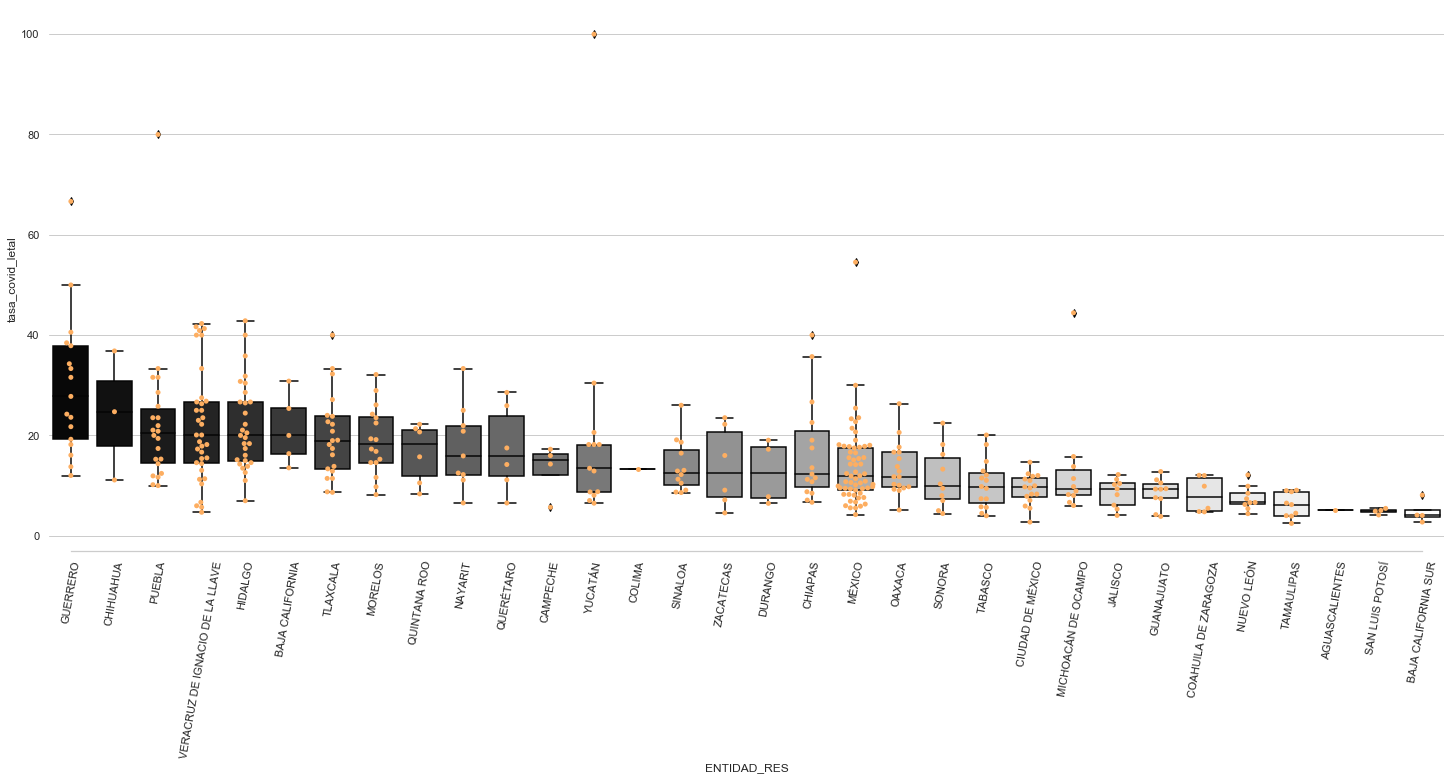

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 15)) &
                          (serie_vulnerabilidad.defunciones > 3)].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['tasa_covid_letal'].transform('median')
df.sort_values(by='mean_val', ascending=False, inplace=True)

sns.boxplot(data=df, y='tasa_covid_letal', x='ENTIDAD_RES', saturation=0.3, palette='Greys_r')
sns.swarmplot(data=df, y='tasa_covid_letal', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

De los municpios desplegados arriba los municipios con mayor letalidad son:

In [ ]:
df.sort_values(by='tasa_covid_letal', ascending=False)[['ENTIDAD_RES',
                                                        'MUNICIPIO_RES',
                                                        'conteo',
                                                        'defunciones',
                                                        'valor', 
                                                        'covid_confirmados_100k', 'tasa_covid_letal',
                                                        'dia_ajuste']].head(20)

,ENTIDAD_RES,MUNICIPIO_RES,conteo,defunciones,valor,covid_confirmados_100k,tasa_covid_letal,dia_ajuste
130544,YUCATÁN,SANAHCAT,4.0,4.0,12.971071,218.698742,100.000000,2020-06-15
129812,PUEBLA,CHILCHOTLA,5.0,4.0,16.979488,23.827678,80.000000,2020-06-15
128583,GUERRERO,HUAMUXTITLÁN,6.0,4.0,13.961738,38.063820,66.666667,2020-06-15
128919,MÉXICO,SOYANIQUILPAN DE JUÁREZ,11.0,6.0,12.759441,76.713857,54.545455,2020-06-15
128584,GUERRERO,HUITZUCO DE LOS FIGUEROA,8.0,4.0,14.704086,20.673971,50.000000,2020-06-15
128975,MICHOACÁN DE OCAMPO,ARTEAGA,9.0,4.0,13.822453,39.440817,44.444444,2020-06-15
128654,HIDALGO,FRANCISCO I. MADERO,14.0,6.0,12.068530,36.009157,42.857143,2020-06-15
130474,VERACRUZ DE IGNACIO DE LA LLAVE,NANCHITAL DE LÁZARO CÁRDENAS DEL RÍO,52.0,22.0,11.057431,166.586577,42.307692,2020-06-15
130398,VERACRUZ DE IGNACIO DE LA LLAVE,PLAYA VICENTE,12.0,5.0,14.895775,30.217566,41.666667,2020-06-15
130443,VERACRUZ DE IGNACIO DE LA LLAVE,TIHUATLÁN,46.0,19.0,14.770386,45.559440,41.304348,2020-06-15


El criterio de desplegar municipios con más de 3 defunciones se aplicó para limpiar los datos. A continuación se presenta el mismo diagrama pero considerando todos los municipios con casos de Sars-CoV-2, se observa que hay varios municipios con cero defunciones y otros con letalidad de 100%, estos son casos que presentan un patrón muy distinto a los demás y habría que investigar a que se debe. 

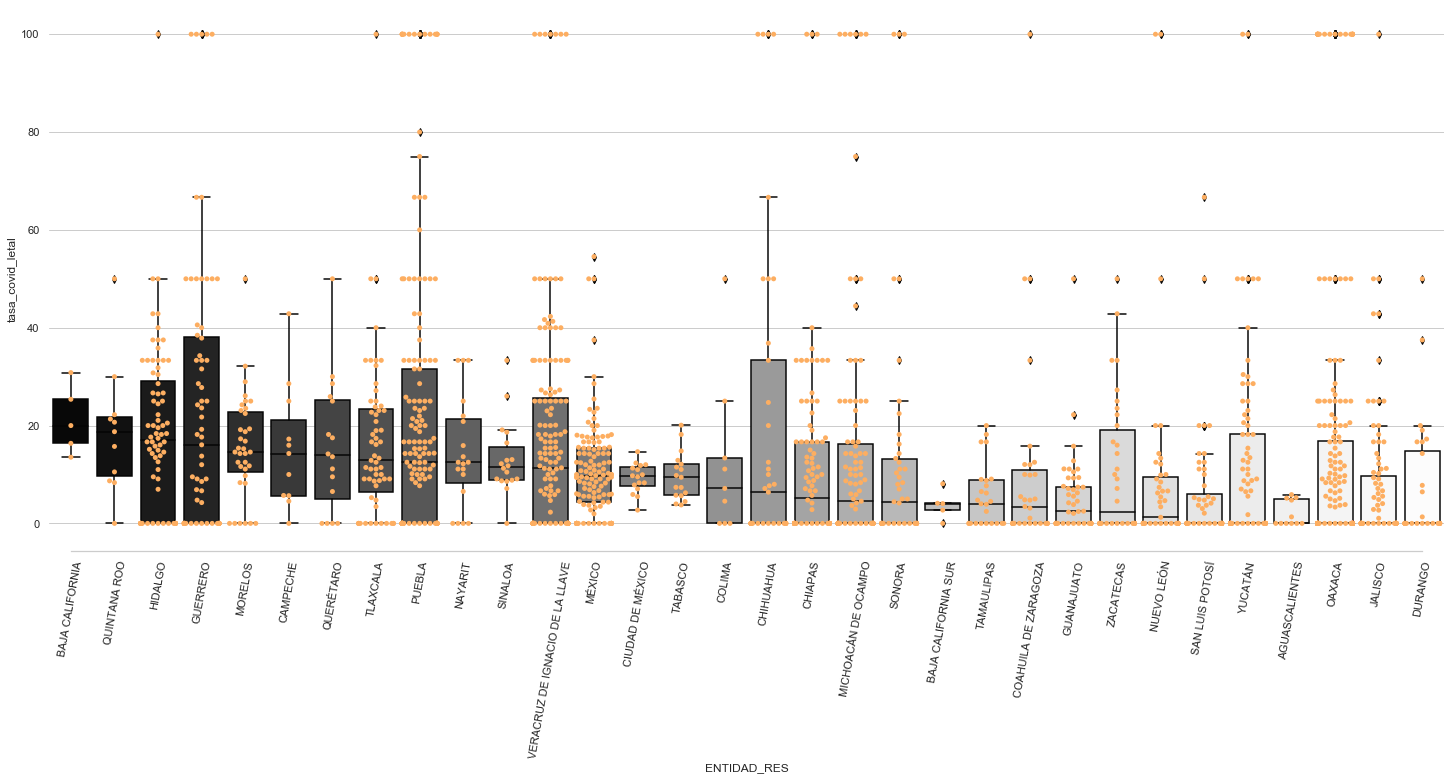

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 15))].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['tasa_covid_letal'].transform('median')
df.sort_values(by='mean_val', ascending=False, inplace=True)

sns.boxplot(data=df[df.conteo > 0], y='tasa_covid_letal', x='ENTIDAD_RES', saturation=0.3, palette='Greys_r')
sns.swarmplot(data=df[df.conteo > 0], y='tasa_covid_letal', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

### Vulnerabilidad por entidad

La siguiente gráfica muestra la distribución de vulnerabilidad de los municipios por entidad. Al igual que en la anterior, cada punto representa un municipio y la posición en el eje *y* está dada por el valor del índice de vulnerabilidad. El orden en el que se despliegan las entidades está dado por la mediana de vulnerabilidad.

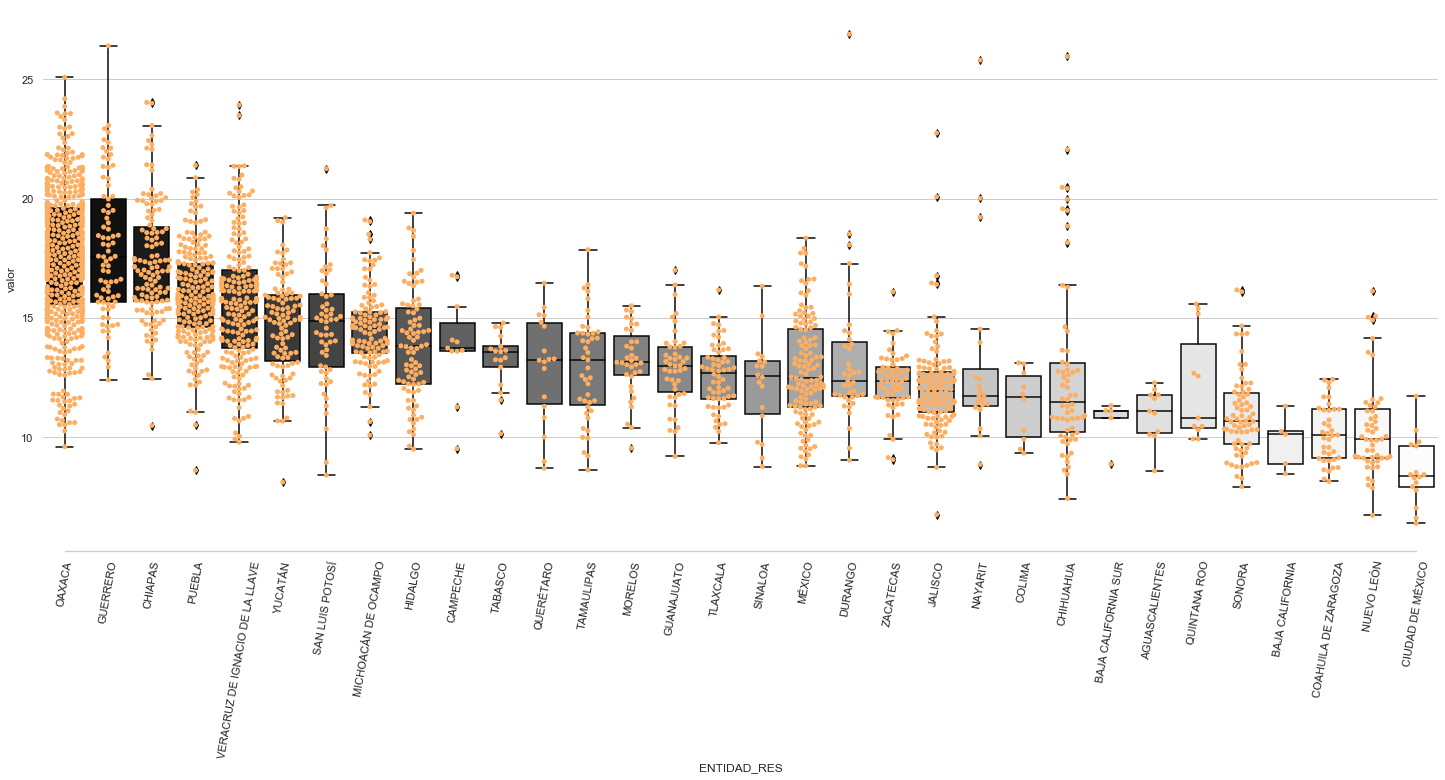

In [ ]:
f, ax = plt.subplots(figsize=(25, 10))
df = serie_vulnerabilidad[(serie_vulnerabilidad.dia_ajuste == datetime.datetime(2020, 6, 1))].copy()
df['mean_val'] = df.groupby('ENTIDAD_RES')['valor'].transform('median')
sns.boxplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', palette='Greys_r')
sns.swarmplot(data=df.sort_values(by='mean_val', ascending=False), y='valor', x='ENTIDAD_RES', color='#fdae61')
plt.xticks(rotation=80)
sns.despine(trim=True, left=True)

### Relación entre el índice de vulnerabilidad y la letalidad

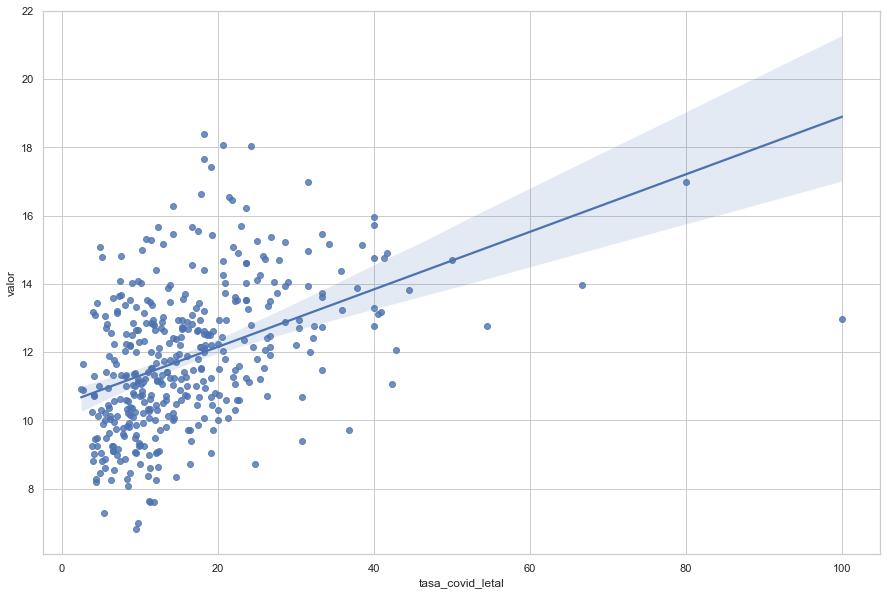

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=df[(df.defunciones > 3)], x='tasa_covid_letal', y='valor')

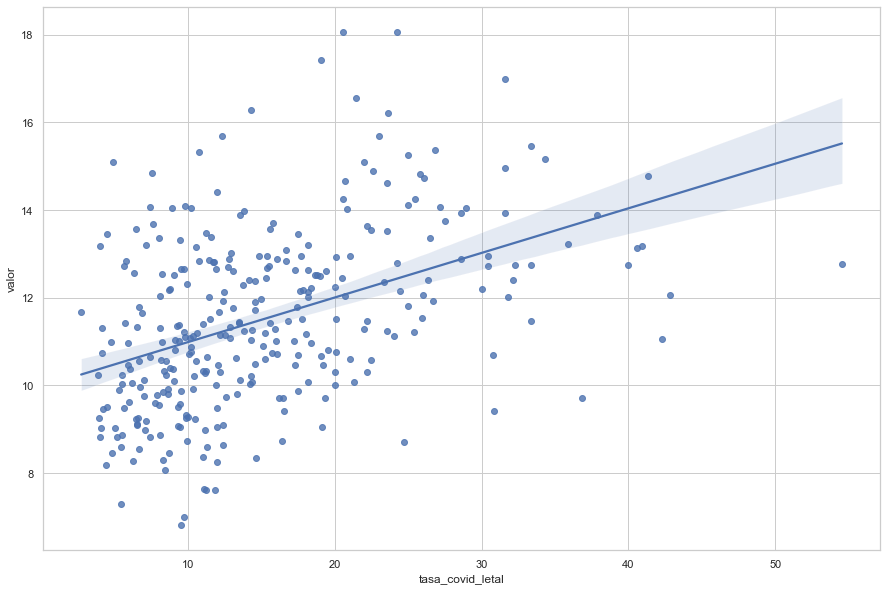

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
sns.regplot(data=df[(df.defunciones > 5)], x='tasa_covid_letal', y='valor')

## Serie de modelos PLS (24/04/2020 - 15/06/2020)

El ajuste de la regresión por PLS asigna coeficientes a cada uno de los indicadores que estamos considerando, donde la magnitud del coeficiente nos indica el tamaño de la relación que se encontró entre el indicador y la letalidad, y el signo nos indica si la relación es proporcional, es decir, si valores grandes del indicador se relacionan con alta vulnerabilidad, o es inversamente proporcional, si conforme crece el valor del indicador decrece el de vulnerabilidad.

El siguiente es un análisis de los modelos resultantes de ajustar una regresión por cada conjunto de datos publicado en el periódo que va del 24/04/2020 al 15/06/2020, es decir para cada día se calculó un modelo de vulnerabilidad. A continuación mostramos las descripciones de los indicadores y cómo se mueven sus coeficientes conforme cambian los datos.

### Descripciones de los indicadores

In [ ]:
lista_cars = list(plss.sort_values(by='mediana', ascending=False)["caracteristica"].drop_duplicates())
pd.set_option('display.max_colwidth', 0)

diccionario_indicadores = diccionario_indicadores.set_index('campo').loc[lista_cars].reset_index()
display(diccionario_indicadores.style.set_properties(**{'text-align': 'left'}))

,campo,descriptor
0,vnl_2015,"Viviendas que no disponen de lavadora,2015"
1,carencias,%Población con al menos una carencia social
2,bi_2015,"15 años y más con educación básica incompleta,2015"
3,ic_ali,%Carencia por acceso a la alimentación
4,ic_rezedu,%Indicadores de carencia social Rezago educativo
5,irs_2015,"Índice de rezago social,2015"
6,ic_segsoc,%Carencia por acceso a la seguridad social
7,pobreza,% Población en situación de pobreza
8,pobreza_m,%Población en situación de pobreza moderada
9,carencias3,%Población con al menos tres carencias sociales


### Distribución de valores de coeficientes por indicador

Este diagrama de cajas muestra los indicadores ordenados con respecto a la mediana de sus coeficientes, en él podemos ver el rango en el que se movieron los coeficientes a lo largo del periodo. Es importante notar aunque los coeficientes de algunos indicadores se mueven en rangos relativamente amplios, en su mayoría se mantienen o en valores positivos o en negativos. 

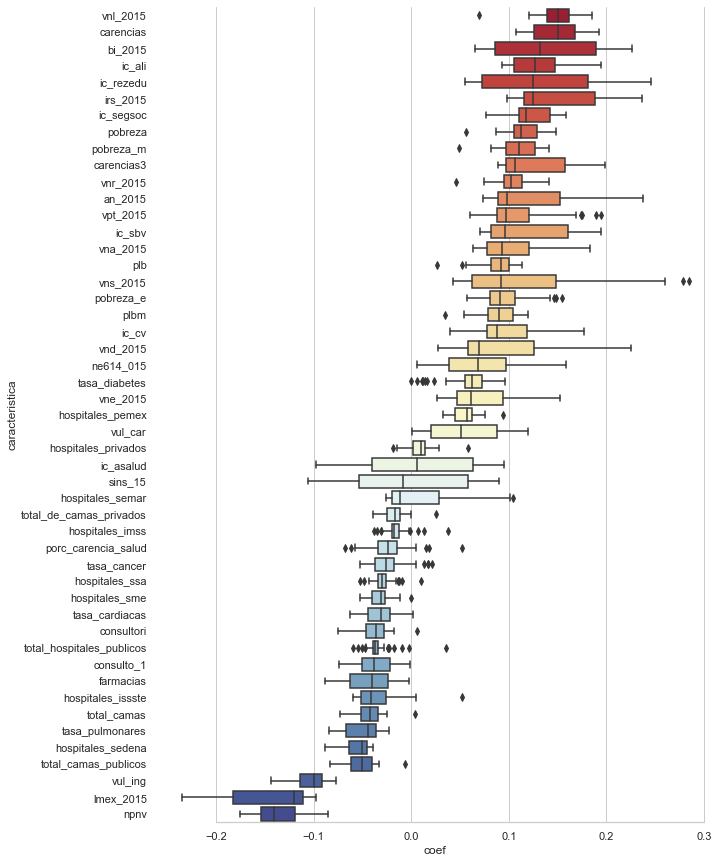

In [ ]:
pd.set_option('display.max_colwidth', 50)
sns.set(style="whitegrid")
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(10, 15))
plss['mediana'] = plss.groupby('caracteristica')['coef'].transform('median')
sns.boxplot(y="caracteristica", x="coef", data=plss.sort_values(by='mediana', ascending=False), palette='RdYlBu')
sns.despine(trim=True, left=True)

### Series de tiempo de coeficientes por indicador

Las siguientes gráficas muestran cómo cambian los coeficientes de los indicadores conforme avanzamos en el día de publicación del conjunto de datos. En general se puede ver que los coeficientes se estabilizan a medida que avanza el tiempo. Además de entender cómo cambia el resultado del ajuste conforme se actualizan los datos, este análisis es una herramienta que podría ayudarnos a detectar cambios en el patrón de letalidad de la epidemia.  

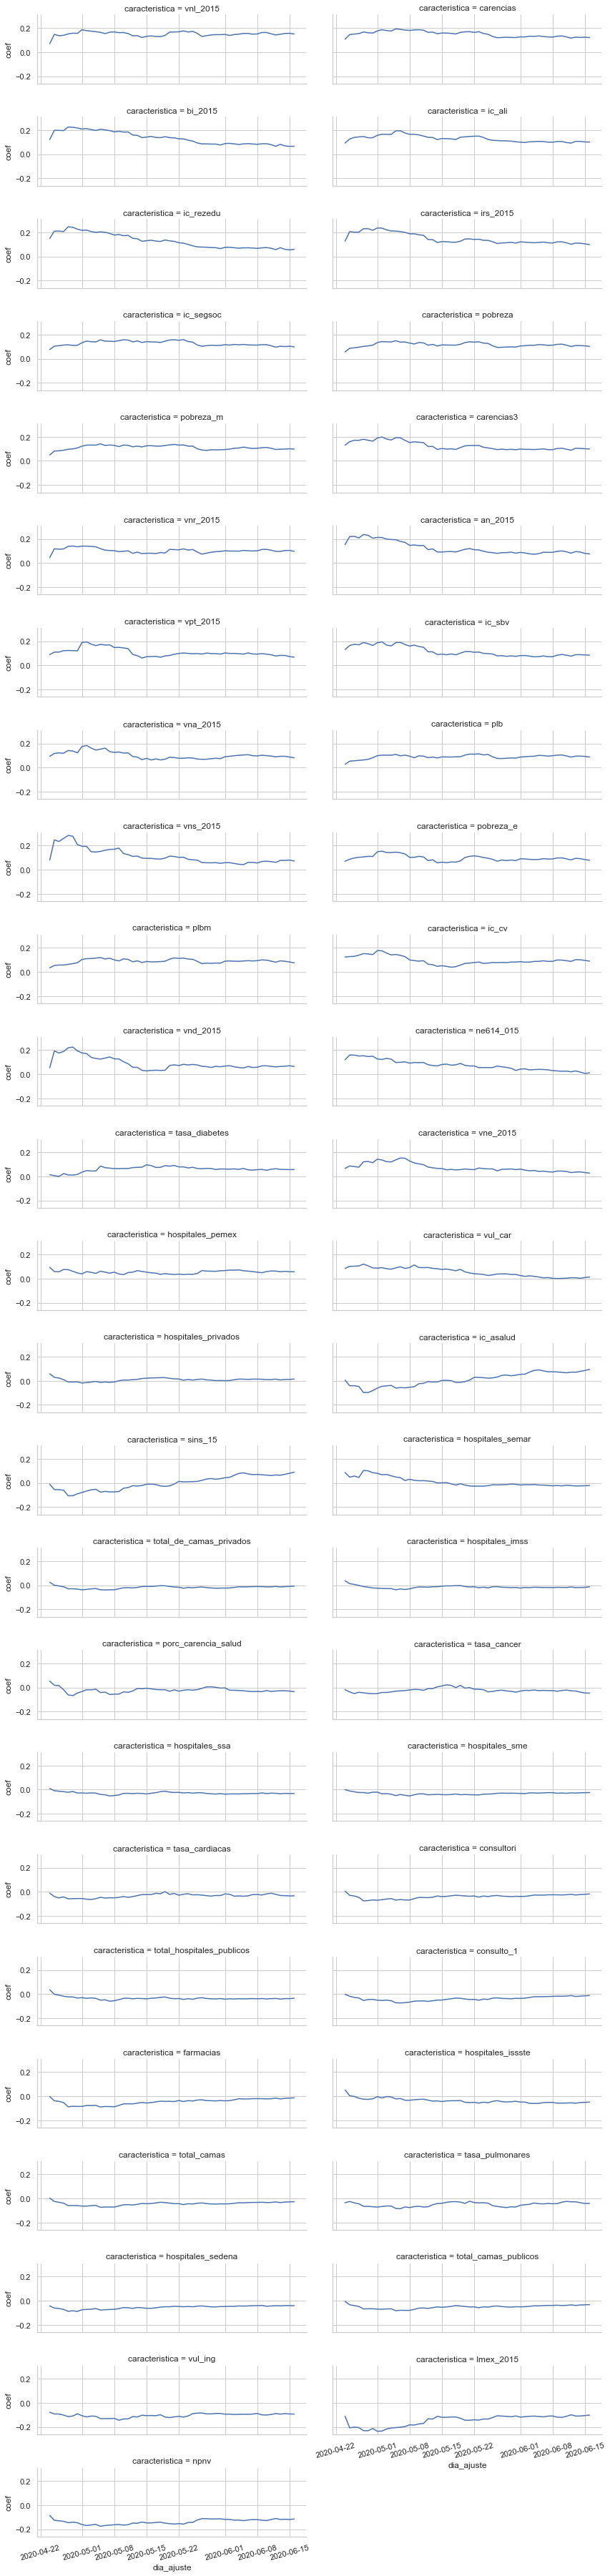

In [ ]:
# ordered_days = tips.day.value_counts().index
orden_plots = plss.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()
g = sns.FacetGrid(plss, col="caracteristica", height=2, aspect=3,
                  col_wrap=2, col_order=orden_plots)
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15)
plt.show()
# sns.pointplot(data=plss[plss.caracteristica == 'ic_rezedu'], x='dia_ajuste', y='coef')

In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()